# NeuralProphet

### Loading Libraries

In [9]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Warnings
import warnings

import plotly.express as px
import tqdm
from tqdm.notebook import tqdm

In [11]:
warnings.filterwarnings('ignore')

In [15]:
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [17]:
import sys
!{sys.executable} -m pip show plotly

Name: plotly
Version: 5.15.0
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: /root/venv/lib/python3.10/site-packages
Requires: packaging, tenacity
Required-by: datascience, neuralprophet


In [23]:
!rm -rf /root/venv/lib/python3.10/site-packages/plotly*
!rm -rf /root/venv/lib/python3.10/site-packages/plotly-*.dist-info

In [25]:
!pip install --no-cache-dir plotly==5.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 170.3 MB/s eta 0:00:00


In [27]:
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed

## Retreiving Data

In [29]:
data_location = "http://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

In [31]:
df = pd.read_csv(data_location + "energy/SF_hospital_load.csv")

In [33]:
df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [35]:
df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


### Splitting Procedure

In [37]:
# NeuralProphet Object
m = NeuralProphet()

- Data Spliting Function: split one time-series dataframe into two

-  Hourly Frequency Configuration: by assigning ('H') to parameter (freq)

- Split Ratio Configuration: with a value between (0 and 1) for valid_p

In [39]:
train_df, test_df = m.split_df(df, freq="H", valid_p=1.0 / 16)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [41]:
train_df.shape, test_df.shape

((8213, 2), (547, 2))

In [43]:
# Training Set
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")

# Test Set
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


## Quantile Regression

- NeuralProphet: only accepts quantiles value in between (0 and 1)

- 

In [45]:
confidence_lv = 0.9
quantile_list = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)]

quantile_list

[0.05, 0.95]

In [47]:
qr_model = NeuralProphet(quantiles=quantile_list)

qr_model.set_plotting_backend("plotly-static")

In [49]:
# Fitting model with the observations
metrics = qr_model.fit(df, freq="H")

# Creating a new DataFrame for prediction
# Including 100 historical values and 30 value points for the future
future = qr_model.make_future_dataframe(df, periods=30, n_historic_predictions=100)

# Trained Models Predictions
forecast = qr_model.predict(df=future)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60
Training: |          | 0/? [00:00<?, ?it/s]WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (137) is too small than the required number                     for the learning rate finder (248). The results might not be optimal.
2025-03-23 22:08:16.883178: I tensorflow/core

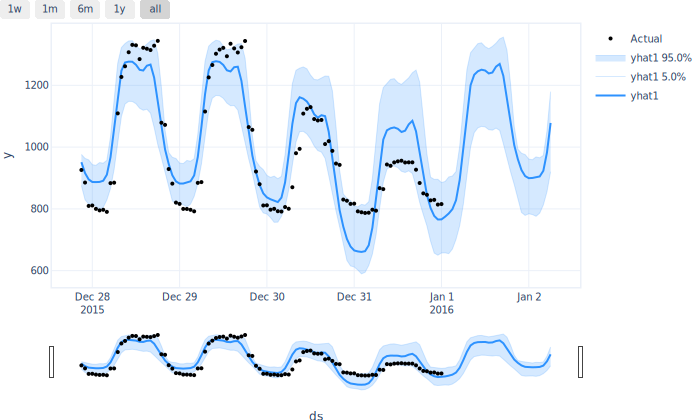

In [51]:
qr_model.plot(forecast)

## Conformal Prediction

### Calibration & Validation Set

In [53]:
# Adding Calibration Set using The Data Splitting Function
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [55]:
train_df.shape, cal_df.shape, test_df.shape

((7467, 2), (746, 2), (547, 2))

In [57]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")

print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")

print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


### Base Model Training

In [59]:
#  AutoRegression Parameter

n_lags = 3 * 24

In [61]:
cp_model1 = NeuralProphet(quantiles=quantile_list)
cp_model1.set_plotting_backend("plotly-static")

cp_model2 = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
    quantiles=quantile_list,
)
cp_model2.set_plotting_backend("plotly-static")

In [63]:
set_random_seed(0)
metrics1 = cp_model1.fit(train_df, freq="H")

set_random_seed(0)
metrics2 = cp_model2.fit(train_df, freq="H")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60
Training: |          | 0/? [00:00<?, ?it/s]WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.

Finding best initial lr: 100%|██████████| 24

- Performing Estimation: Testing Data on Trained Model

In [64]:
forecast1 = cp_model1.predict(test_df)[n_lags:]

forecast2 = cp_model2.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 364.56it/s]
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.49it/s]
INFO - (NP.df_utils.return_df_in_orig

### Option 1: Naïve Conformal Prediction

In [66]:
# Parameter for naive conformal prediction
method = "naive"
alpha = 1 - confidence_lv

# Enable conformal predict on the pre-trained models
# Evaluate parameter is optional, refer to the "Evaluate Performance" session below
naive_forecast1 = cp_model1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    show_all_PI=True,
)
naive_forecast2 = cp_model2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    show_all_PI=True,
)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.18it/s]INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 374.93it/s]INFO - (NP.df_utils.return_df_in_origi

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.02it/s]INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.11it/s]
INFO - (NP.df_utils.return_df_in_origi

In [68]:
naive_forecast1

,ds,y,yhat1,yhat1 - qhat1,yhat1 + qhat1,trend,season_weekly,season_daily,yhat1 5.0%,yhat1 95.0%
0,2015-12-09 06:00:00,803.410865,986.211914,826.323425,1146.100342,1030.976074,-36.357544,-8.406521,898.949402,1077.043335
1,2015-12-09 07:00:00,868.264194,1087.415039,927.526550,1247.303467,1030.992188,-44.147152,100.570030,982.120178,1180.354980
2,2015-12-09 08:00:00,975.752982,1146.608521,986.720032,1306.497070,1031.008301,-52.561150,168.161301,1047.781494,1229.768311
3,2015-12-09 09:00:00,983.268943,1155.297119,995.408630,1315.185547,1031.024536,-60.754822,185.027374,1071.773193,1238.744385
4,2015-12-09 10:00:00,1095.825986,1146.330566,986.442078,1306.218994,1031.040649,-69.140640,184.430557,1069.997925,1235.107544
...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,833.305237,673.416748,993.193726,1039.736084,-100.520248,-105.910645,746.842285,931.532349
543,2015-12-31 21:00:00,827.530521,795.605530,635.717041,955.494019,1039.752197,-91.509911,-152.636795,698.650574,884.134399
544,2015-12-31 22:00:00,829.256300,773.339172,613.450684,933.227661,1039.768433,-82.373810,-184.055466,664.933228,884.649902
545,2015-12-31 23:00:00,813.937205,765.239685,605.351196,925.128174,1039.784668,-73.369743,-201.175171,658.067200,880.031372


In [70]:
# Conforma Prediction Evaluation - Model 1
naive_qhat1 = naive_forecast1.iloc[-1]["yhat1"] - naive_forecast1.iloc[-1]["yhat1 - qhat1"]  

# Conforma Prediction Evaluation - Model 2
naive_qhat2 = naive_forecast2.iloc[-1]["yhat1"] - naive_forecast2.iloc[-1]["yhat1 - qhat1"]  
naive_qhat1, naive_qhat2

(159.88849, 30.474548)

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


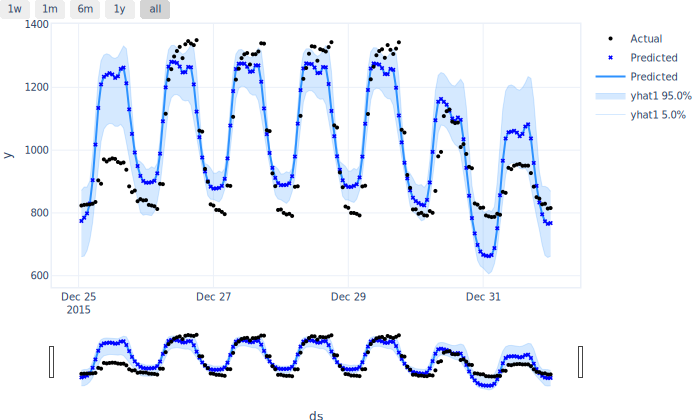

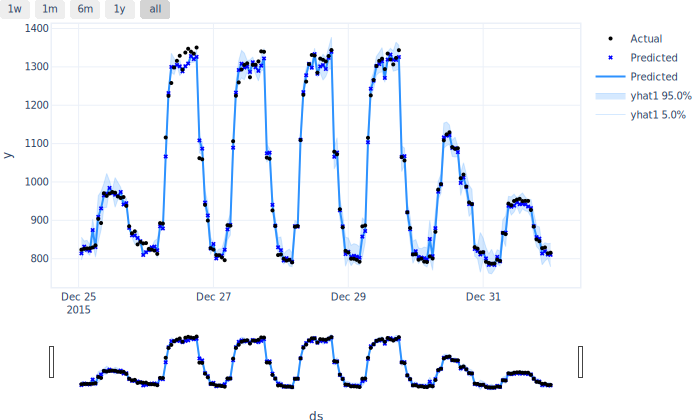

In [72]:
cutoff = 7 * 24

fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], plotting_backend="plotly-static"
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], plotting_backend="plotly-static"
)

### Option 2: Conformalized Quantile Regression

In [74]:
# Quantile Regression Conformal Prediction
method = "cqr"

cqr_forecast1 = cp_model1.conformal_predict(
    test_df, calibration_df=cal_df, alpha=alpha, method=method, plotting_backend="plotly-static"
)
cqr_forecast2 = cp_model2.conformal_predict(
    test_df, calibration_df=cal_df, alpha=alpha, method=method, plotting_backend="plotly-static"
)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 290.97it/s]INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 320.67it/s]
INFO - (NP.df_utils.return_df_in_orig

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.38it/s]INFO - (NP.df_utils.return_df_in_origi

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


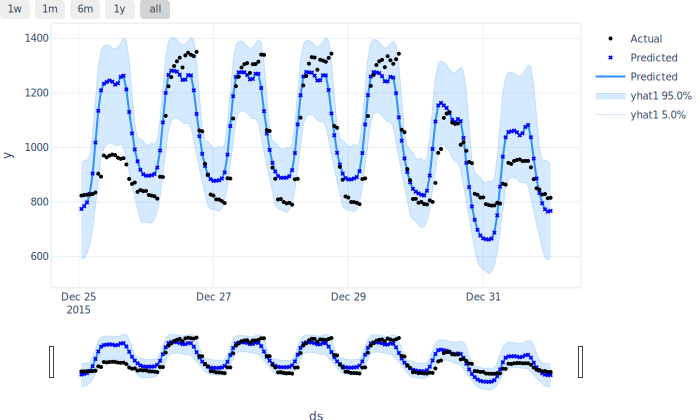

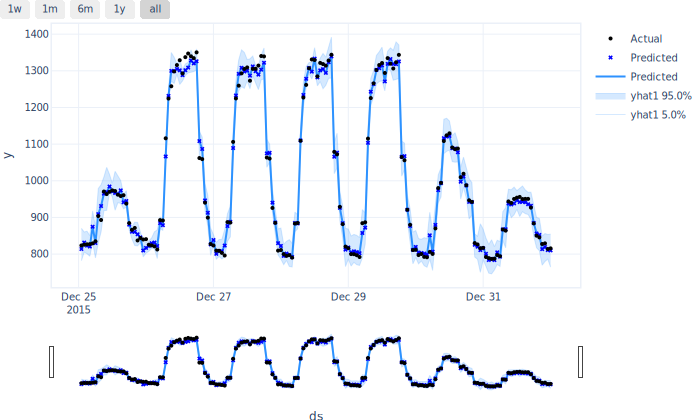

In [76]:
fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], plotting_backend="plotly-static"
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], plotting_backend="plotly-static"
)

## Performance Evaluation

In [78]:
# Two Model Skeleton
models = ["m1", "m2"]

eval_df = pd.DataFrame(models, columns=pd.MultiIndex.from_tuples([("model", "", "")]))

In [80]:
# Extracting the naive performance metrics from their respective forecast datasets
naive_eval1 = uncertainty_evaluate(naive_forecast1)
naive_eval2 = uncertainty_evaluate(naive_forecast2)

# Aggregating the naive performance metrics for m1 and m2
naive_evals = [naive_eval1, naive_eval2]
naive_eval_df = pd.concat(naive_evals).reset_index(drop=True)

In [82]:
# Extracting the cqr performance metrics from their respective forecast datasets
cqr_eval1 = uncertainty_evaluate(cqr_forecast1)
cqr_eval2 = uncertainty_evaluate(cqr_forecast2)

# Aggregating the cqr performance metrics for m1 and m2
cqr_evals = [cqr_eval1, cqr_eval2]
cqr_eval_df = pd.concat(cqr_evals).reset_index(drop=True)

- Concatenating Models

In [84]:
eval_df = pd.concat([naive_eval_df, cqr_eval_df], axis=1, keys=["naive", "cqr"])
eval_df

naive                             cqr                 
           yhat1                           yhat1                 
  interval_width miscoverage_rate interval_width miscoverage_rate
0     319.776978         0.109689     306.757751         0.104205
1      60.948975         0.052632      75.613220         0.029474

- Quantile Outcome Comparisons:

In [86]:
qr_eval = uncertainty_evaluate(forecast1)
qr_eval

yhat1                 
  interval_width miscoverage_rate
0     161.619568         0.463158

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52ebbe0f-44fe-4e13-ada9-9aa16f2a072b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>